In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k

data = pd.read_csv('preprocessed.csv')
sample_size = 150000
if len(data) > sample_size:
    data = data.sample(n=sample_size, random_state=42)

unique_users = data['customer_id'].unique()
unique_items = data['product_id'].unique()
user_map = {id: idx for idx, id in enumerate(unique_users)}
item_map = {id: idx for idx, id in enumerate(unique_items)}
data['user_idx'] = data['customer_id'].apply(lambda x: user_map[x])
data['item_idx'] = data['product_id'].apply(lambda x: item_map[x])

num_users = len(unique_users)
num_items = len(unique_items)
row = data['user_idx']
col = data['item_idx']
rating = data['star_rating']
input_matrix = csr_matrix((rating, (row, col)), shape=(num_users, num_items))

c:\Users\jyc02\anaconda3\envs\project\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [2]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd

interaction_matrix = input_matrix
interaction_matrix = interaction_matrix.astype(np.float32)

k = 20 # number of latent factors
u, s, vt = svds(interaction_matrix, k=k)

s_diag_matrix = np.diag(s)
interaction_matrix_reconstructed = np.dot(np.dot(u, s_diag_matrix), vt)

def recommend_items(user_id, interaction_mat, k=10):
    user_row = interaction_mat[user_id,:]
    item_ids = np.argsort(user_row)[::-1][:k]
    return item_ids

In [14]:
selected_num_user = 5000
rand_selection = np.random.choice(num_users, selected_num_user, replace=False)
points = []

for user_id in rand_selection:
    item_ids = recommend_items(user_id, interaction_matrix_reconstructed, 5)
    print("Top 5 recommendations for user {}: {}".format(user_id, item_ids))
    points.append(item_ids)

Top 5 recommendations for user 77339: [ 592 1010  141   85 1072]
Top 5 recommendations for user 21003: [ 791  501  836  155 1037]
Top 5 recommendations for user 60946: [ 791  256  501 1010  598]
Top 5 recommendations for user 1072: [ 141  234  249 1037   85]
Top 5 recommendations for user 4438: [ 791  501 1037  139   85]
Top 5 recommendations for user 121900: [ 791  501 1037  139   85]
Top 5 recommendations for user 40968: [141 840 598 245 435]
Top 5 recommendations for user 104410: [1037   85  592   96  141]
Top 5 recommendations for user 59361: [256 592 234 840 598]
Top 5 recommendations for user 79199: [ 85  96 501  82 139]
Top 5 recommendations for user 118719: [510  82 791 155 249]
Top 5 recommendations for user 23744: [256 836 510 155 139]
Top 5 recommendations for user 115518: [ 791  510  249 1037   82]
Top 5 recommendations for user 99633: [  85  245  249 1330  266]
Top 5 recommendations for user 114699: [ 501   96  155   82 1072]
Top 5 recommendations for user 62146: [ 245  59

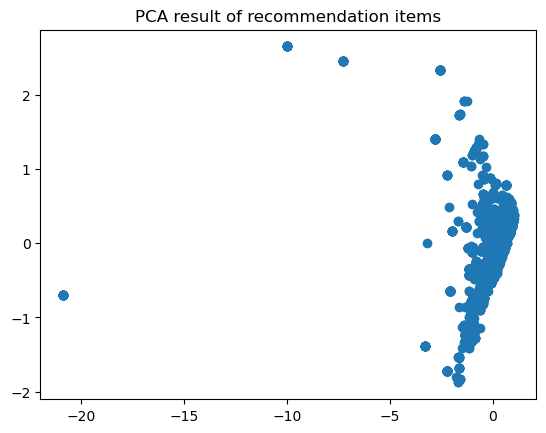

In [16]:
# PCA
X = np.array(points)
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
cov = np.cov(X.T)
eigenvalues, eigenvectors = np.linalg.eig(cov)
k = 2
top_k_eigenvectors = eigenvectors[:, :k]
X_new = np.dot(X, top_k_eigenvectors)

import matplotlib.pyplot as plt
plt.scatter(X_new[:, 0], X_new[:, 1])
plt.title("PCA result of recommendation items")
plt.show()